# 01: K-means クラスタリング

このノートブックでは、教師なし学習の代表的な手法である「クラスタリング」の基本、特に最も広く知られている**K-means**アルゴリズムについて学びます。
K-meansは、そのシンプルさと計算速度から、多くの分野で利用されている強力な手法です。

このノートブックでは、まずK-meansの元々のアルゴリズム（Lloyd's algorithm）をNumPyでスクラッチ実装し、その仕組みを深く理解します。その後、K-meansの最大の弱点である「初期値依存性」を改善するための、非常に効果的な初期化手法である<b>K-means++</b>についても学び、実装します。

**参考論文:**
*   (K-means) Lloyd, S. P. (1982). Least squares quantization in PCM. *IEEE Transactions on Information Theory*, 28(2), 129-137.
*   (K-means++) Arthur, D., & Vassilvitskii, S. (2007). k-means++: The advantages of careful seeding. *In Proceedings of the eighteenth annual ACM-SIAM symposium on Discrete algorithms*.

**このノートブックで学ぶこと:**
1.  K-meansクラスタリングの目的：クラスタ内平方和（WCSS）の最小化。
2.  Lloyd's algorithmの2つのステップ：クラスタ割り当てとセントロイド更新。
3.  NumPyを用いたK-meansのスクラッチ実装。
4.  K-meansの弱点である、初期セントロイドの選び方による結果の不安定性。
5.  賢い初期化手法であるK-means++のアルゴリズムとその実装。
6.  ランダム初期化とK-means++の結果の比較。

**前提知識:**
*   ユークリッド距離の計算。
*   NumPyによるベクトル・行列演算。
*   Matplotlibによるデータの可視化。

## 1. 必要なライブラリのインポート

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # データセット生成のため

# npの乱数シードを設定
np.random.seed(42)

## 2. K-meansアルゴリズムの理論

K-meansは、与えられたデータセット $X = \{\boldsymbol{x}_1, \boldsymbol{x}_2, \dots, \boldsymbol{x}_N\}$ を、事前（a priori）に定めたクラスタ数 $K$ 個の互いに素なクラスタ $C = \{C_1, C_2, \dots, C_K\}$ に分割するアルゴリズムです。

### 2.1 目的関数

K-meansの目的は、**クラスタ内平方和（Within-Cluster Sum of Squares, WCSS）**を最小化することです。これは、各データポイントとその所属するクラスタのセントロイド（中心点）との間のユークリッド距離の二乗和として定義されます。

$$
\min_{\boldsymbol{\mu}_1, \dots, \boldsymbol{\mu}_K} \sum_{k=1}^{K} \sum_{\boldsymbol{x}_i \in C_k} ||\boldsymbol{x}_i - \boldsymbol{\mu}_k||^2
$$

ここで、
*   $C_k$ はクラスタ $k$ に属するデータポイントの集合。
*   $\boldsymbol{\mu}_k$ はクラスタ $k$ のセントロイド（重心）。

この最適化問題を厳密に解くことはNP困難であることが知られています。そのため、K-meansでは**Lloyd's algorithm**として知られる、局所最適解を見つけるための反復的なヒューリスティック手法が用いられます。

### 2.2 Lloyd's Algorithm

Lloyd's algorithmは、以下の2つのステップを収束するまで繰り返します。

1.  **クラスタ割り当て (Assignment Step)**:
    各データポイント $\boldsymbol{x}_i$ を、現在最も近いセントロイド $\boldsymbol{\mu}_k$ を持つクラスタ $C_k$ に割り当てます。
    $$
    C_k = \{ \boldsymbol{x}_i : ||\boldsymbol{x}_i - \boldsymbol{\mu}_k||^2 \le ||\boldsymbol{x}_i - \boldsymbol{\mu}_j||^2 \quad \forall j, 1 \le j \le K \}
    $$

2.  **セントロイド更新 (Update Step)**:
    各クラスタ $C_k$ について、そのクラスタに割り当てられた全てのデータポイントの平均（重心）を計算し、それを新しいセントロイド $\boldsymbol{\mu}_k$ とします。
    $$
    \boldsymbol{\mu}_k = \frac{1}{|C_k|} \sum_{\boldsymbol{x}_i \in C_k} \boldsymbol{x}_i
    $$

この2つのステップを繰り返すと、目的関数であるWCSSは単調に減少し、最終的にセントロイドの更新が止まった時点（局所最適解）でアルゴリズムは収束します。

## 3. K-meansのスクラッチ実装

それでは、上記のアルゴリズムをNumPyで実装してみましょう。

### 3.1 データの準備

`sklearn.datasets.make_blobs` を使って、クラスタリングに適した人工データを生成します。

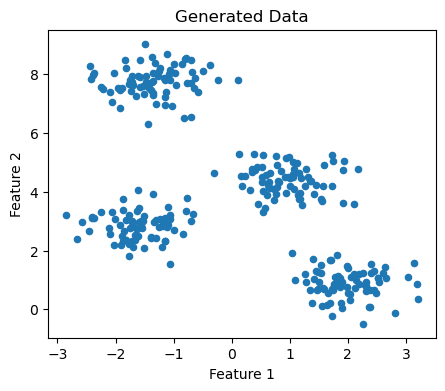

In [69]:
# 人工データの生成
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.5, random_state=0)

# データをプロット
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], s=20)
plt.title("Generated Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### 3.2 K-meansクラスの実装

In [70]:
class KMeans:
    def __init__(self, n_clusters=4, max_iter=100, random_state=None, init_method='random'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.init_method = init_method 
        self.centroids = None
        self.labels = None
    
    def _initialize_centroids(self, x):
        '''セントロイドの初期化'''
        if self.random_state:
            np.random.seed(self.random_state)

        if self.init_method == 'random':
            random_indices = np.random.permutation(x.shape[0])
            self.centroids = x[random_indices[:self.n_clusters]]
        elif self.init_method == 'kmeans++':
            # KMeans++ の実装（後述）
            self.centroids = np.zeros((self.n_clusters, x.shape[1]))
        else:
            raise ValueError("Init method must be 'random' or 'kmeans++'")
        
    def _assign_clusters(self, x):
        '''各データ点を最も近いセントロイドに割り当てる'''
        distances = np.zeros((x.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            # 各データ点と各セントロイドの距離を計算
            distances[:, k] = np.sum((x - self.centroids[k])**2, axis=1)
        
        # 最も近いセントロイドのインデックスを取得
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, x, labels):
        '''新しいセントロイドを計算'''
        new_centroids = np.zeros((self.n_clusters, x.shape[1]))
        for k in range(self.n_clusters):
            # クラスタkに属するデータ点の平均を計算
            cluster_points = x[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
        return new_centroids
    
    def fit(self, x):
        '''K-meansアルゴリズムの実行'''
        # セントロイドの初期化
        self._initialize_centroids(x) 

        for i in range(self.max_iter):
            # クラスタ割り当て
            self.labels = self._assign_clusters(x)
            # セントロイドの更新
            new_centroids = self._update_centroids(x, self.labels)

            # 収束判定：セントロイドが変化しなくなったら終了
            if np.allclose(self.centroids, new_centroids):
                break
            
            self.centroids = new_centroids
        
        return self

    def predict(self, x):
        '''新しいデータ点のクラスタを予測'''
        return self._assign_clusters(x)

### 3.3 ランダム初期化によるK-meansの実行と可視化

まずは、最も基本的なランダム初期化でK-meansを実行してみます。`random_state`を変えて何度か実行し、結果がどのように変わるかを見てみましょう。

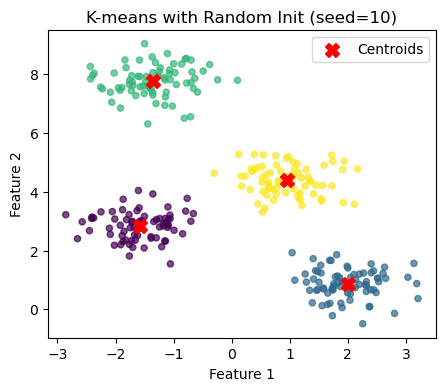

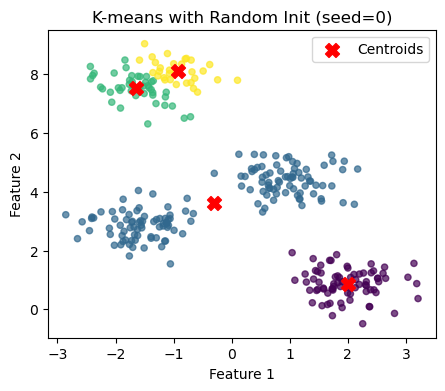

In [71]:
def plot_kmeans_result(X, labels, centroids, title):
    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis', alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X', label='Centroids')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

# --- 実行例 1 --
kmeans_random1 = KMeans(n_clusters=4, random_state=10, init_method='random')
kmeans_random1.fit(X)
plot_kmeans_result(X, kmeans_random1.labels, kmeans_random1.centroids, "K-means with Random Init (seed=10)")

# --- 実行例 2（悪い例） ---
kmeans_random2 = KMeans(n_clusters=4, random_state=0, init_method='random')
kmeans_random2.fit(X)
plot_kmeans_result(X, kmeans_random2.labels, kmeans_random2.centroids, "K-means with Random Init (seed=0)")

**結果の考察**

`seed=10`の場合はうまくクラスタリングできているように見えますが、`seed=0`の場合は明らかに不適切なクラスタリング（局所最適解）に陥っています。これは、初期セントロイドの選び方が偶然悪かったためです。

このように、ランダムな初期化を用いるK-meansは、結果が不安定で、良いクラスタリングを得るためには複数回実行して最も良い結果を選ぶなどの工夫が必要になります。この問題を解決するのがK-means++です。

## 4. K-means++: 賢い初期化手法

K-means++は、初期セントロイドを完全にランダムに選ぶのではなく、**互いに離れた位置にセントロイドが選ばれやすくなるように**工夫した手法です。

### 4.1 K-means++のアルゴリズム

1.  最初のセントロイド $\boldsymbol{\mu}_1$ を、データセット $X$ からランダムに1つ選びます。

2.  2番目からK番目までの各セントロイドを、以下の手順で選びます。  
    a.  各データポイント $\boldsymbol{x}_i$ について、既に選ばれているセントロイド集合との**最短距離の二乗** $D(\boldsymbol{x}_i)^2$ を計算します。
        $$
        D(\boldsymbol{x}_i)^2 = \min_{k=1, \dots, K_{selected}} ||\boldsymbol{x}_i - \boldsymbol{\mu}_k||^2
        $$
    b.  データセット内の全ての点について計算した $D(\boldsymbol{x})^2$ の値に**比例した確率**で、次のセントロイドとなるデータポイント $\boldsymbol{x}_j$ を選びます。
        $$
        P(\boldsymbol{x}_j \text{ is chosen}) = \frac{D(\boldsymbol{x}_j)^2}{\sum_{i=1}^{N} D(\boldsymbol{x}_i)^2}
        $$

3.  このプロセスを、セントロイドがK個選ばれるまで繰り返します。

この手順により、既に選ばれているセントロイドから遠いデータポイントほど、次に選ばれる確率が高くなります。これにより、初期セントロイドがデータ空間全体にばらけて配置され、K-meansがより良い解に収束しやすくなります。

### 4.2 K-means++初期化の実装

`KMeans`クラスにK-means++の初期化ロジックを追加します。

In [72]:
def kmeans_plus_plus_init(self, x):
    '''K-means++の初期化'''
    # 元のメソッドの機能を含める
    if self.random_state:
        np.random.seed(self.random_state)

    if self.init_method == 'random':
        # 元のランダム初期化ロジック
        random_indices = np.random.permutation(x.shape[0])
        self.centroids = x[random_indices[:self.n_clusters]]
    elif self.init_method == 'kmeans++':
        # K-means++初期化
        n_samples, n_features = x.shape
        centroids = np.zeros((self.n_clusters, n_features))

        # 最初のセントロイドをランダムに選択
        first_idx = np.random.randint(n_samples)
        centroids[0] = x[first_idx]

        # 残りのセントロイドを選択
        for k in range(1, self.n_clusters):
            # 各データ点と既存のセントロイドとの最短距離の二乗を計算
            distances_sq = np.array([
                np.min([np.sum((point - centroid) ** 2) for centroid in centroids[:k]])
                for point in x
            ])

            # D(x)^2に比例して確率的に次のセントロイドを選択
            probs = distances_sq / np.sum(distances_sq)
            cumulative_probs = np.cumsum(probs)
            r = np.random.rand()

            next_idx = np.searchsorted(cumulative_probs, r)
            centroids[k] = x[next_idx]

        # 重要：self.centroidsに代入
        self.centroids = centroids
    else:
        raise ValueError("Init method must be 'random' or 'kmeans++'")

# KMeansクラスにK-means++の初期化を追加
KMeans._initialize_centroids = kmeans_plus_plus_init

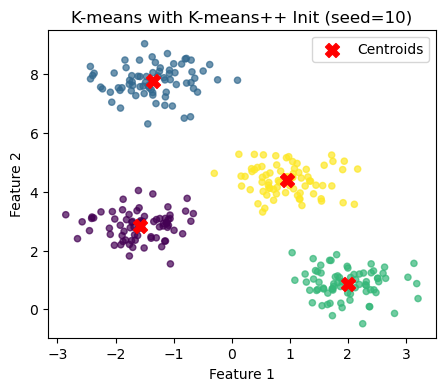

In [73]:
# K-means++ を使って実行 (先ほど失敗したseed=0で試す)
kmeans_pp = KMeans(n_clusters=4, random_state=0, init_method='kmeans++')
kmeans_pp.fit(X)
plot_kmeans_result(X, kmeans_pp.labels, kmeans_pp.centroids, "K-means with K-means++ Init (seed=10)")

## 5. まとめと考察

このノートブックでは、K-meansクラスタリングの基本であるLloyd's algorithmと、その初期化を改善するK-means++について学び、それぞれをスクラッチ実装しました。

*   **K-means (Lloyd's algorithm)** は、クラスタ割り当てとセントロイド更新を繰り返すことで、クラスタ内平方和（WCSS）を局所的に最小化するシンプルで高速なアルゴリズムです。
*   しかし、その性能は**初期セントロイドの選び方に大きく依存**し、不適切な初期値は質の悪いクラスタリング（局所最適解）につながります。
*   **K-means++** は、データポイントと既存セントロイドとの距離に比例した確率で次のセントロイドを選ぶという「賢い」初期化を行うことで、この問題を大幅に改善します。これにより、初期セントロイドがデータ空間に広く分布しやすくなり、アルゴリズムがより良い解に、かつより速く収束することが期待できます。

**実践的なガイドライン:**
*   現代の機械学習ライブラリ（例: scikit-learn）では、K-meansのデフォルトの初期化手法として**K-means++が採用**されています。これは、その安定性と性能の高さが広く認められているためです。
*   K-meansを適用する際は、クラスタ数 $K$ を事前に決める必要があります。この $K$ を決定するための手法として、エルボー法やシルエット分析などがありますが、それらはまた別のトピックとなります。

このノートブックを通して、クラスタリングの基本的な考え方と、アルゴリズムの性能を改善するための洗練されたアイデア（K-means++）を、実装レベルで理解することができました。